Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [55]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
from copy import deepcopy, copy
import matplotlib.pyplot as plt
from dataclasses import dataclass
from random import random, choice, randint, choices, gauss
import numpy as np
from tqdm import tqdm


## The *Nim* and *Nimply* classes

In [56]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [57]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


In [58]:
def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)

## Sample (and silly) startegies 

In [59]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [60]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


## Optimal strategy

In [61]:
def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = choice(spicy_moves)
    return ply


## Wiki Optimal

In [69]:
def check_state(state: Nim) -> tuple:
    found = False
    total = 0
    counter = 0
    row = 0
    empty_rows = 0
    for r in state.rows:
        if r == 0:
            empty_rows += 1

        if r >= 2 and not found:
            found = True
            total = r
            row = counter
        elif r >= 2 and found:
            found = False
            break

        counter += 1
    
    if found:
        return row, total, counter - empty_rows
    else:
        return -1, -1, -1

def wiki_optimal(state: Nim) -> Nimply:
    row, tot, not_empty_rows = check_state(state)
    if row != -1:
        if not_empty_rows % 2 == 0: #even number of non empty rows
            ply = Nimply(row, tot)
        else:                       #odd number of non empty rows
            ply = Nimply(row, tot-1)
    else:
        analysis = analize(state)
        logging.debug(f"analysis:\n{pformat(analysis)}")
        spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns == 0]
        if not spicy_moves:
            spicy_moves = list(analysis["possible_moves"].keys())
        ply = choice(spicy_moves)
    return ply

## True Wiki Optimal

In [70]:
def analize2(raw: Nim):
    cooked = dict()
    cooked["possible_moves"] = dict()
    counter = 0
    for r in raw.rows:
        new_xor = r ^ nim_sum(raw)
        if new_xor < r:
            ply = Nimply(counter, r - new_xor)
            cooked["possible_moves"][ply] = new_xor

        counter += 1

    return cooked
            
def check_state(state: Nim) -> tuple:
    found = False
    total = 0
    counter = 0
    row = 0
    empty_rows = 0
    for r in state.rows:
        if r == 0:
            empty_rows += 1

        if r >= 2 and not found:
            found = True
            total = r
            row = counter
        elif r >= 2 and found:
            found = False
            break

        counter += 1
    
    if found:
        return row, total, counter - empty_rows
    else:
        return -1, -1, -1

def wiki_optimal2(state: Nim) -> Nimply:
    row, tot, not_empty_rows = check_state(state)
    if row != -1:
        if not_empty_rows % 2 == 0: #even number of non empty rows
            ply = Nimply(row, tot)
        else:                       #odd number of non empty rows
            ply = Nimply(row, tot-1)
    else:
        analysis = analize2(state)
        logging.debug(f"analysis:\n{pformat(analysis)}")
        spicy_moves = list(analysis["possible_moves"].keys())

        if len(spicy_moves) == 0:
            ply = pure_random(state)
        else:
            ply = choice(spicy_moves)
    return ply

## Evolution Strategy

In [62]:
@dataclass
class Individual:
    fitness: int
    row: int
    poss: list
    weights: np.array
    strategy: Nimply

In [63]:
def populate(state: Nim) -> [Individual]:
    population = []

    for r in range(len(state.rows)):
        possibilities = []
        if state.rows[r] != 0:
            for d in range(1, state.rows[r]+1):
                possibilities.append(d)

        i = Individual(
            row = r,
            poss = possibilities ,
            weights = np.random.uniform(0, 1, len(possibilities)),
            fitness = 0,
            strategy = Nimply(r, -1)
        )
        population.append(i)

    return population

In [64]:
def fitness(state: Nim, ply: Nimply):
    fit = 0

    counter = 0
    found = False
    empty_rows = 0

    for r in state.rows:
        if r == 0:
            empty_rows += 1

        if counter != ply.row and r >= 2:
            found = False
            break
        elif counter == ply.row and r >= 2:
            found = True
            
        counter += 1

    if found:
        fit = 2

        if (len(state.rows) - empty_rows) % 2 == 0: #even number of non empty rows
            if ply.num_objects == state.rows[ply.row]:
                fit += 3
        else:
            if ply.num_objects == state.rows[ply.row] - 1: #odd number of non empty rows
                fit += 3
    else:
        tmp = deepcopy(state)
        tmp.nimming(ply)

        if nim_sum(tmp) == 0:
            fit = 1

    return fit

In [65]:
def mutate(i: Individual, mut_rate: float) -> Individual:
    we = deepcopy(i.weights)

    for w in range(len(i.weights)):
        if random() < mut_rate:
            we[w] += gauss(0, 0.01)
            if we[w] <= 0:
                we[w] = 0.1

    new_i = Individual(
        fitness = 0,
        row = i.row,
        poss = i.poss,
        weights = we,
        strategy = Nimply(i.row, -1)
    )

    return new_i

In [66]:
def choose_num_obj(i: Individual):
    if len(i.poss) > 0:
        probabilities = deepcopy(i.poss)

        for w in range(len(i.poss)):
            probabilities[w] = i.weights[w] / np.sum(i.weights)
        
        l_index = choices(range(len(probabilities)), weights = probabilities, k = 1)

        poss = i.poss[l_index[0]]
    else:
        poss = -1

    return poss

In [67]:
def es(state: Nim) -> Nimply:
    population = populate(state)

    for i in population:
        w = choose_num_obj(i)
        if w == -1: #NO OBJECTS TO CHOOSE FROM THAT ROW
            i.fitness = -1
            continue
        i.strategy = Nimply(i.row, w)
        i.fitness = fitness(state, Nimply(i.row, w))

    population.sort(key = lambda x:x.fitness, reverse = True)

    parent = population[0]

    for _ in range(1_000 // 5): #GENERATION
        children = []
        for _ in range(5):
            new_i = mutate(parent, 0.5)

            new_w = choose_num_obj(new_i)
            new_i.strategy = Nimply(new_i.row, new_w)
            new_i.fitness = fitness(state, Nimply(new_i.row, new_w))

            children.append(new_i)

        children.append(deepcopy(parent))

        population = deepcopy(children)

        population.sort(key = lambda x:x.fitness, reverse = True)
        
        parent = population[0]

    return population[0].strategy

In [68]:
nim = Nim(5)

es(nim)

Nimply(row=4, num_objects=9)

## Oversimplified match

In [71]:
logging.getLogger().setLevel(logging.INFO)

strategy = (es, pure_random)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 3 5 7 9>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=6)
INFO:root:status: <0 3 5 1 9>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=3)
INFO:root:status: <0 0 5 1 9>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=5)
INFO:root:status: <0 0 0 1 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=9)
INFO:root:status: <0 0 0 1 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=1)
INFO:root:status: <0 0 0 0 0>
INFO:root:status: Player 0 won!


## 100 Matches

In [72]:
def draw_pie_chart(win_rate, title):
    labels = ['Wins', 'Losses']
    sizes = [win_rate, 100 - win_rate]
    colors = ['#4CAF50', '#FF5252']

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
    
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    ax.axis('equal')  
    
    plt.title(title)
    plt.show()

## ES (1 + lambda)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:51<00:00,  1.92it/s]


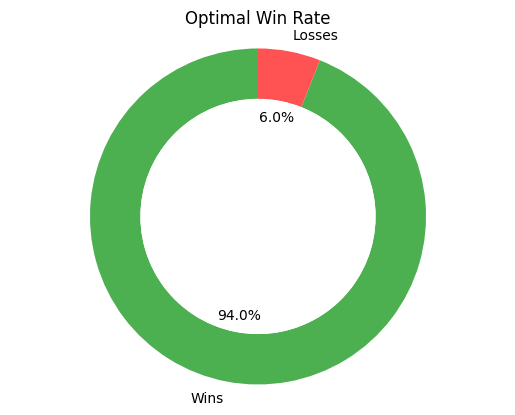

In [73]:
logging.getLogger().setLevel(logging.INFO)

strategy = (es, pure_random)

count_win = 0

for _ in tqdm(range(100)):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 0 :
        count_win += 1

draw_pie_chart(count_win, "Optimal Win Rate")

## True Wiki Optimal

100%|██████████| 100/100 [00:00<00:00, 821.31it/s]


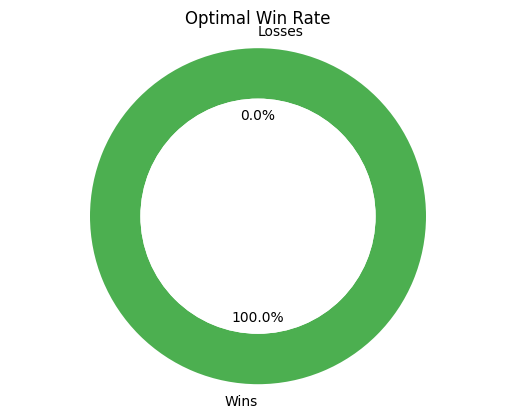

In [74]:
logging.getLogger().setLevel(logging.INFO)

strategy = (wiki_optimal2, pure_random)

count_win = 0

for _ in tqdm(range(100)):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 0 :
        count_win += 1

draw_pie_chart(count_win, "Optimal Win Rate")

## Wiki Optimal

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 254.31it/s]


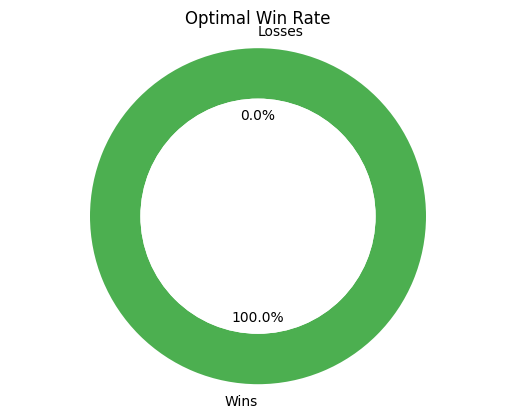

In [75]:
logging.getLogger().setLevel(logging.INFO)

strategy = (wiki_optimal, pure_random)

count_win = 0

for _ in tqdm(range(100)):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 0 :
        count_win += 1

draw_pie_chart(count_win, "Optimal Win Rate")

## Optimal starts first

100%|██████████| 100/100 [00:00<00:00, 200.07it/s]


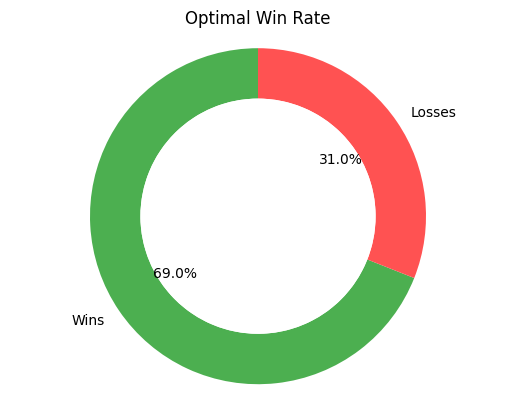

In [76]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

count_win = 0

for _ in tqdm(range(100)):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 0 :
        count_win += 1

draw_pie_chart(count_win, "Optimal Win Rate")

## Optimal starts second

100%|██████████| 100/100 [00:00<00:00, 207.23it/s]


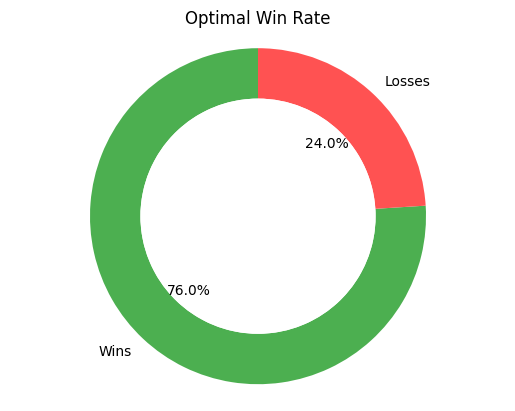

In [77]:
logging.getLogger().setLevel(logging.INFO)

strategy = (pure_random, optimal)

count_win = 0

for _ in tqdm(range(100)):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 1 :
        count_win += 1

draw_pie_chart(count_win, "Optimal Win Rate")

## Optimal VS Optimal

100%|██████████| 100/100 [00:00<00:00, 106.87it/s]


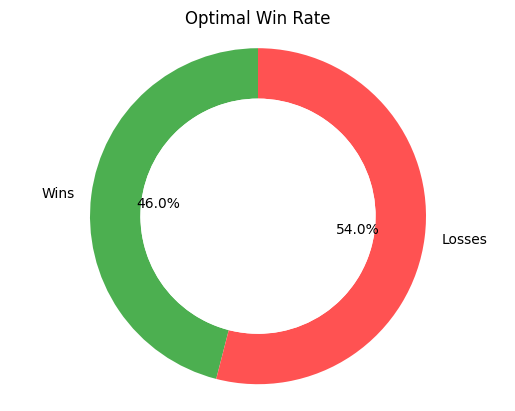

In [78]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, optimal)

count_win = 0

for _ in tqdm(range(100)):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 0 :
        count_win += 1

draw_pie_chart(count_win, "Optimal Win Rate")

## Pure Random

100%|██████████| 100/100 [00:00<00:00, 21274.68it/s]


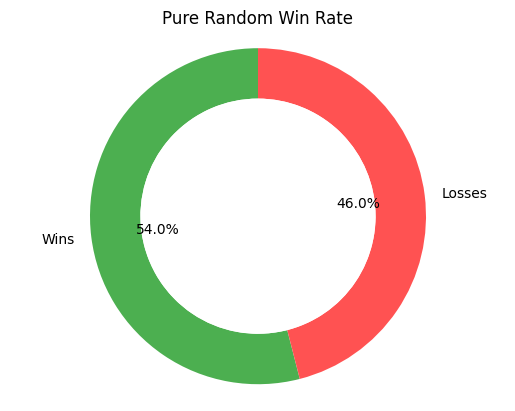

In [79]:
logging.getLogger().setLevel(logging.INFO)

strategy = (pure_random, pure_random)

count_win = 0

for _ in tqdm(range(100)):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 0 :
        count_win += 1

draw_pie_chart(count_win, "Pure Random Win Rate")